In [1]:
import os
import cv2
import random
import time 

import numpy as np
import pandas as pd
import seaborn as sns
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras import layers, Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import *
from tensorflow.keras.models import *

from sklearn.model_selection import train_test_split,KFold
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.metrics import accuracy_score, top_k_accuracy_score, f1_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

2024-03-15 13:47:19.880300: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-15 13:47:19.880393: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-15 13:47:19.987500: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
%matplotlib inline

In [3]:
img_size = (150,150)
BATCH = 32

In [4]:
len(os.listdir('/kaggle/input/brain-tumor-mri-images-44c/'))

44

In [5]:
data_path= "/kaggle/input/brain-tumor-mri-images-44c"

In [6]:
df = pd.DataFrame(columns=['path','label'])

In [7]:
folder = os.listdir(data_path)
def create_df(df,folder,data_path):
    for fold in folder:
        class_path = os.path.join(data_path,fold)
        class_folder = os.listdir(class_path)
        for img in class_folder:
            img_path = os.path.join(class_path,img)
            df = df._append({'path':os.path.join(class_path,img) , 'label' : fold.split()[1]},ignore_index=True)
    return df

In [8]:
df = create_df(df,folder,data_path)
df.head()

,path,label
0,/kaggle/input/brain-tumor-mri-images-44c/Papil...,T2
1,/kaggle/input/brain-tumor-mri-images-44c/Papil...,T2
2,/kaggle/input/brain-tumor-mri-images-44c/Papil...,T2
3,/kaggle/input/brain-tumor-mri-images-44c/Papil...,T2
4,/kaggle/input/brain-tumor-mri-images-44c/Papil...,T2


In [9]:
df.shape

(4479, 2)

In [10]:
#df.to_pickle('initial_dataset.pkl')


In [11]:
#df = pd.read_pickle('/kaggle/working/initial_dataset.pkl')
df.head()

,path,label
0,/kaggle/input/brain-tumor-mri-images-44c/Papil...,T2
1,/kaggle/input/brain-tumor-mri-images-44c/Papil...,T2
2,/kaggle/input/brain-tumor-mri-images-44c/Papil...,T2
3,/kaggle/input/brain-tumor-mri-images-44c/Papil...,T2
4,/kaggle/input/brain-tumor-mri-images-44c/Papil...,T2


In [12]:
df.shape

(4479, 2)

In [13]:
label_counts = df['label'].value_counts().sort_values(ascending=False)
sorted_label = label_counts.index

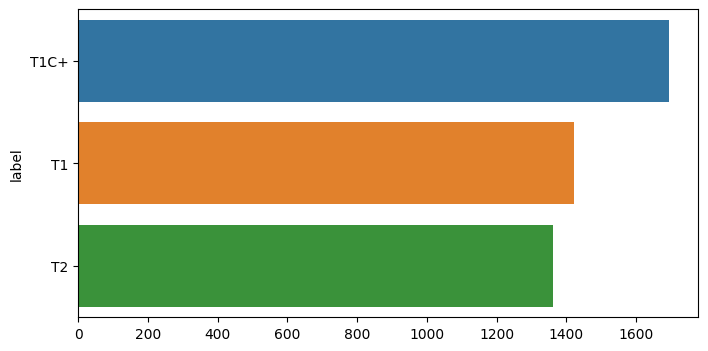

In [14]:
plt.figure(figsize=(8,4))
sns.barplot(x=label_counts.values, y=sorted_label)
plt.show()

In [15]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
)

In [16]:
df_shuffle = df.sample(frac=1).reset_index(drop=True)
df_shuffle.head()

,path,label
0,/kaggle/input/brain-tumor-mri-images-44c/Menin...,T2
1,/kaggle/input/brain-tumor-mri-images-44c/Germi...,T1
2,/kaggle/input/brain-tumor-mri-images-44c/Menin...,T1
3,/kaggle/input/brain-tumor-mri-images-44c/Schwa...,T1C+
4,/kaggle/input/brain-tumor-mri-images-44c/Oligo...,T1C+


In [17]:
train_df, tv_df = train_test_split(df,test_size= 0.2,shuffle=True,random_state=42,stratify= df['label'])
test_df, valid_df = train_test_split(tv_df,test_size= 0.5,shuffle=True,random_state=42,
                                          stratify= tv_df['label'])

In [18]:
train_df

,path,label
4082,/kaggle/input/brain-tumor-mri-images-44c/Schwa...,T1
1166,/kaggle/input/brain-tumor-mri-images-44c/Menin...,T2
1566,/kaggle/input/brain-tumor-mri-images-44c/Oligo...,T1C+
1309,/kaggle/input/brain-tumor-mri-images-44c/Neuro...,T2
2061,/kaggle/input/brain-tumor-mri-images-44c/Neuro...,T1C+
...,...,...
3419,/kaggle/input/brain-tumor-mri-images-44c/Astro...,T1C+
3196,/kaggle/input/brain-tumor-mri-images-44c/Astro...,T1
918,/kaggle/input/brain-tumor-mri-images-44c/Germi...,T1C+
3962,/kaggle/input/brain-tumor-mri-images-44c/Papil...,T1


In [19]:
test_df


,path,label
1942,/kaggle/input/brain-tumor-mri-images-44c/Gliob...,T1C+
1215,/kaggle/input/brain-tumor-mri-images-44c/Menin...,T2
3363,/kaggle/input/brain-tumor-mri-images-44c/Astro...,T1C+
3302,/kaggle/input/brain-tumor-mri-images-44c/Astro...,T1C+
3797,/kaggle/input/brain-tumor-mri-images-44c/Schwa...,T2
...,...,...
1570,/kaggle/input/brain-tumor-mri-images-44c/Oligo...,T1C+
1201,/kaggle/input/brain-tumor-mri-images-44c/Menin...,T2
2871,/kaggle/input/brain-tumor-mri-images-44c/Menin...,T1C+
1547,/kaggle/input/brain-tumor-mri-images-44c/Oligo...,T1C+


In [20]:
valid_df

,path,label
3535,/kaggle/input/brain-tumor-mri-images-44c/Papil...,T1C+
4335,/kaggle/input/brain-tumor-mri-images-44c/Germi...,T2
2756,/kaggle/input/brain-tumor-mri-images-44c/Menin...,T1C+
141,/kaggle/input/brain-tumor-mri-images-44c/Tuber...,T1C+
3556,/kaggle/input/brain-tumor-mri-images-44c/Papil...,T1C+
...,...,...
2988,/kaggle/input/brain-tumor-mri-images-44c/Menin...,T1C+
811,/kaggle/input/brain-tumor-mri-images-44c/Schwa...,T1C+
3626,/kaggle/input/brain-tumor-mri-images-44c/Papil...,T1C+
100,/kaggle/input/brain-tumor-mri-images-44c/Tuber...,T1C+


In [21]:
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='label',
    target_size=img_size,  # Resize images to 150x150
    color_mode='rgb',
    class_mode="categorical",  # "raw" for regression tasks, "binary" for binary classification
    batch_size=BATCH,
    shuffle=True
)

Found 3582 validated image filenames belonging to 3 classes.


In [22]:
valid_generator = datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='path',
    y_col='label',
    target_size=img_size,  # Resize images to 150x150
    color_mode='rgb',
    class_mode="categorical",  # "raw" for regression tasks, "binary" for binary classification
    batch_size=BATCH,
    shuffle=True
)

Found 448 validated image filenames belonging to 3 classes.


In [23]:
test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='label',
    target_size=img_size,  # Resize images to 150x150
    color_mode='rgb',
    class_mode="categorical",  # "raw" for regression tasks, "binary" for binary classification
    batch_size=BATCH,
    shuffle=True
)

Found 448 validated image filenames belonging to 3 classes.


In [24]:
'''
import zipfile

base_dir = '/kaggle/working'

def zipdir(path, ziph):
    for root, dirs, files in os.walk(path):
        for file in files:
            ziph.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), os.path.join(path, '..')))

with zipfile.ZipFile(os.path.join(base_dir, 'augmented_images.zip'), 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipdir('augmented_images/', zipf)

for pkl_file in ['augmented_balanced_dataset.pkl', 'initial_dataset.pkl']:
    with zipfile.ZipFile(os.path.join(base_dir, f"{pkl_file}.zip"), 'w', zipfile.ZIP_DEFLATED) as zipf:
        zipf.write(os.path.join(base_dir, pkl_file), pkl_file)

print('Created separate ZIP files for each item.')
'''


'\nimport zipfile\n\nbase_dir = \'/kaggle/working\'\n\ndef zipdir(path, ziph):\n    for root, dirs, files in os.walk(path):\n        for file in files:\n            ziph.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), os.path.join(path, \'..\')))\n\nwith zipfile.ZipFile(os.path.join(base_dir, \'augmented_images.zip\'), \'w\', zipfile.ZIP_DEFLATED) as zipf:\n    zipdir(\'augmented_images/\', zipf)\n\nfor pkl_file in [\'augmented_balanced_dataset.pkl\', \'initial_dataset.pkl\']:\n    with zipfile.ZipFile(os.path.join(base_dir, f"{pkl_file}.zip"), \'w\', zipfile.ZIP_DEFLATED) as zipf:\n        zipf.write(os.path.join(base_dir, pkl_file), pkl_file)\n\nprint(\'Created separate ZIP files for each item.\')\n'